In [3]:
%load_ext autoreload
%autoreload 2

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial as fct
import sympy as sp

In [92]:
%matplotlib inline
sp.init_printing()

$$y' +' = e^{-\varepsilon x}, \quad y(0) = a$$

In [88]:
# True solution
def yt(x, a, eps):
    return np.exp(-eps*x)/(1-eps) + (a-1/(1-eps))*np.exp(-x)

# Sympy version
def yt_s(x, a, eps):
    return sp.exp(-eps*x)/(1-eps) + (a-1/(1-eps))*sp.exp(-x)

In [89]:
x_s = sp.Symbol('x')
a_s = sp.Symbol('a')
eps_s = sp.Symbol('varepsilon')

# Calculate asymptotics

In [5]:
# Leading order solution
def y0(x, a):
    return 1 + (a-1) * np.exp(-x)

In [71]:
# Integral of x^n e^x
@np.vectorize
def I_c(x, n):
    s = 0
    for k in range(n+1):
        s += (-1)**(n-k)*fct(n)/fct(k)*x**k
    return s * np.exp(x)

def I(x, n):
    return I_c(x, n) - I_c(0, n)

In [79]:
# n-th term in asymptotic expansion
def y_a(x, n):
    return (-1)**n * I(x, n) * np.exp(-x) / fct(n)

# n-th order approximate solution
@np.vectorize
def u(x, a, eps, n):
    sol = y0(x, a)
    for k in range(1, n+1):
        sol += eps**k * y_a(x, k)
    
    return sol

# Calculate McClaurin

In [112]:
@np.vectorize
def M(x, a, eps, n):
    s = yt(0, a, eps)
    for k in range(1, n+1):
        deriv = sp.diff(yt_s(x_s, a_s, eps_s), eps_s, k)
        deriv_n = sp.lambdify((x_s, a_s, eps_s,), deriv, modules=("numpy",))
        s += deriv_n(x, a, 0) * eps**k / fct(k)
    return s

# Plot both together

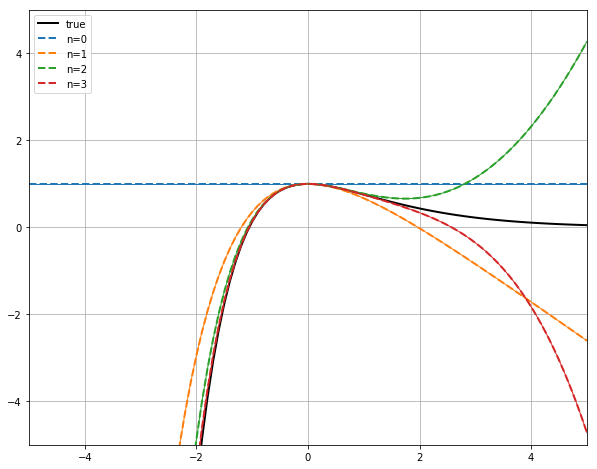

In [116]:
a = 1
eps = 0.9
N = 3

plt.figure(figsize=(10,8))

x = np.linspace(-5, 5, 101)
plt.plot(x, yt(x, a, eps), 'k-', lw=2, label='true')
for n in range(N+1):
    plt.plot(x, u(x, a, eps, n), 'C{}-'.format(n), lw=1)
    plt.plot(x, M(x, a, eps, n), 'C{}--'.format(n), lw=2, label='n={}'.format(n))

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid()
plt.legend()

Clearly, the asymptotic approximations are the McClaurin approximations.

# Convergence plots

In [127]:
from scipy.optimize import curve_fit

In [152]:
def lin_model(x, m, b):
    return m*x + b

def exp_model(x, m, b):
    return np.exp(b)*x**m

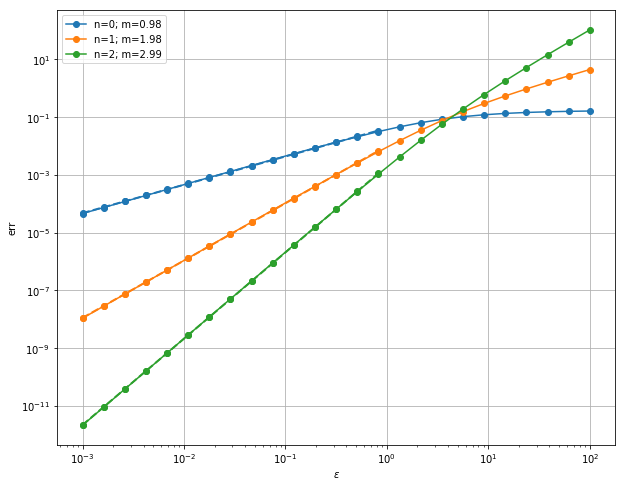

In [185]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))
model = exp_model

eps_arr = np.logspace(-3, 2, 25, base=10)
eps_max = 1

plt.figure(figsize=(10,8))

for n in range(N):
    err_list = []
    for eps in eps_arr:
        approx = u(x, a, eps, n)
        true = yt(x, a, eps)
        err = norm(approx - true)
        err_list.append(err)
        
    err_arr = np.array(err_list)

    popt, _ = curve_fit(lin_model, np.log(eps_arr[eps_arr<=eps_max]), np.log(err_arr[eps_arr<=eps_max]), p0=(1, 1))
    m, b = popt
    plt.plot(eps_arr, err_arr, 'C{}o-'.format(n), label='n={}; m={:.2f}'.format(n, m))
    plt.plot(eps_arr[eps_arr<eps_max], model(eps_arr[eps_arr<eps_max], m, b), 'C{}o--'.format(n), lw=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\varepsilon$')
plt.ylabel('err')
plt.grid()
plt.legend()

So the $n$-th approximation should converge with order $n+1$ as $\varepsilon \to 0$.